In [1]:
DATASET_data = "rec_mu2e.CRV_wideband_cosmics.CRVWB-000-010-000-011.root"
DATASETS_MC = [
    "nts.mu2e.WidebandCRV_v25.MDC2020an.root",
    "nts.mu2e.WidebandCRV_v26.MDC2020an.root",
    "nts.mu2e.WidebandCRV_v27.MDC2020an.root",
    "nts.mu2e.WidebandCRV_v28.MDC2020an.root",
    "nts.mu2e.WidebandCRV_v29.MDC2020an.root",
    "nts.mu2e.WidebandCRV_v30.MDC2020an.root"
]

In [2]:
import time
import os
import re

from mu2etools import *
from mu2etools import wideband
hep.style.use('ATLAS')  # or ATLAS/LHCb2
import hist
from hist import Hist
import mplhep as mplhep
from scipy.stats import binom
from scipy.stats import norm

In [3]:
#List of variable to export to a skimmed array
varlist=['PEs', 'spillNumber', 'eventNumber','runNumber', 'subrunNumber',
         'trackPEs', 'trackPoints', 'trackChi2', 'trackIntercept', 'trackSlope']

#List of variable to add to a skimmed array
varlist.extend(['nTrigHits', 'PEsTestLayers'])

#List of optional variables to add to a skimmed array
keep_trig = False
if keep_trig:
    varlist.extend(['PEsTrigLayers'])

In [4]:
def customFilter(ar, layer_indices, channel_ranges):
    all_layers = np.arange(0,16) 
    test_layers = np.arange(4,8) # Test layers are 4-7
    trig_layers = all_layers[~np.isin(all_layers, test_layers)]
    # Filter out hits below 5PE
    ar_trig_filt = ak.where(ar['PEs'] >= 5, ar['PEs'], 0)
    #Calculate PEs per layer
    PEs_layer = []
    for idx, (start, end) in zip(layer_indices, channel_ranges):
        PEs_layer.append(ak.sum(ar_trig_filt[:, idx, start:end], axis=-1))
    ar['PEsAllLayer'] = np.stack(PEs_layer, axis=-1) # PEs_stacked
    # Count the number of triggered layers
    ar['nTrigHits'] = ak.sum(ar['PEsAllLayer'][:, trig_layers] > 10, axis=-1)
    # Filter out events with more than 10 triggered layers        
    ar = ar[ar['nTrigHits'] > 8]
    # Extract PEsTestLayers and PEsTrigLayers
    ar['PEsTestLayers'] = ar['PEsAllLayer'][:, test_layers]
    ar['PEsTrigLayers'] = ar['PEsAllLayer'][:, trig_layers]
    # drop "PEs" field to save memory
    ar = ak.without_field(ar, "PEs")
    return ar

In [5]:
%%time
# Define the channel map
layer_indices = np.array([1, 1, 0, 0, 3, 3, 2, 2, 5, 5, 4, 4, 7, 7, 6, 6])
channel_ranges = [(32, 64), (0, 32)] * 8

# Create the processor
processor = wideband.DataProcessor(
    treename='CrvWidebandTest/run',
    filter_name=varlist,
    filter_func=customFilter,
    filter_args=(layer_indices, channel_ranges),
    fixtimes=False
)

# Loop over datasets and retrieve awkward arrays
ar_mc_list = [
    processor.getData(ds, max_workers=100, step_size="1000MB", nfiles=1000)
    for ds in DATASETS_MC
]

Processing file: nts.mu2e.WidebandCRV_v25.MDC2020an.103001_00000023.root - 0.4% complete

/home/oksuzian/.conda/envs/MyEnv/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:454: RuntimeWarning: invalid value encountered in cast
  return self._module.concatenate(arrays, axis=axis, casting="same_kind")


Processing file: nts.mu2e.WidebandCRV_v30.MDC2020an.103001_00001389.root - 100.0% completeCPU times: user 2h 13min 48s, sys: 1h 11min 21s, total: 3h 25min 9s
Wall time: 1h 28min 16s


In [6]:
%%time
layer_indices = np.array([0, 0, 6, 6, 1, 1, 2, 2, 3, 3, 4, 4, 7, 7, 5, 5])
channel_ranges = [(32, 64), (0, 32)] * 8
processor = wideband.DataProcessor(
    treename='run', filter_name=varlist, 
    filter_func=customFilter, 
    filter_args=(layer_indices, channel_ranges), 
    fixtimes=False
)

ar_data = processor.getData(DATASET_data, max_workers=100, step_size="100MB", nfiles=-1) # get akward array for "run" tree

Processing file: rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-010-000.002024_000.root - 100.0% completeCPU times: user 5min 24s, sys: 3min 49s, total: 9min 13s
Wall time: 2min 7s


In [10]:
zip(ar_mc_list, MC_labels)

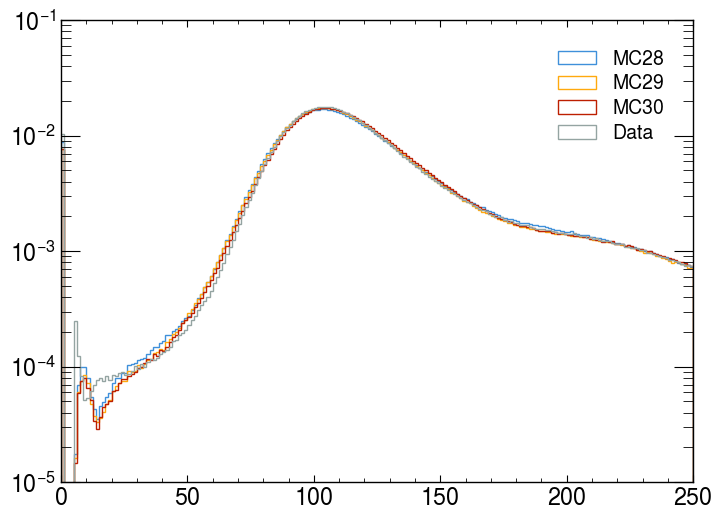

In [11]:
MC_labels = ['MC25', 'MC26', 'MC27', 'MC28', 'MC29', 'MC30']

# Loop over each MC array and label, and make the histogram
for ar_mc, label in zip(ar_mc_list[-3:], MC_labels[-3:]):
    plt.hist(ar_mc['PEsTestLayers'][:, 0], 
             range=(0, 250), bins=200, histtype='step', 
             label=label, density=True)

# Plot the data as well
plt.hist(ar_data['PEsTestLayers'][:, 0], 
         range=(0, 250), bins=200, histtype='step', 
         label='Data', density=True)

plt.yscale('log')
plt.legend()
plt.show()

In [17]:
# Assign dataType = 'MC25', 'MC26', etc. to each MC array
for label, arr in zip(MC_labels, ar_mc_list):
    arr["dataType"] = label

# Assign dataType = 'Data' (or any other string) to the data array
ar_data["dataType"] = "Data"

# Concatenate all MC arrays into one Awkward array
ar_mc = ak.concatenate(ar_mc_list)

In [18]:
ar_mc['trackPoints'] = ar_mc['trackPoints'][:,0]
ar_mc['trackChi2'] = ar_mc['trackChi2'][:,0]
ar_mc['trackSlope'] = ar_mc['trackSlope'][:,0]
ar_mc['trackIntercept'] = ar_mc['trackIntercept'][:,0]
ar_mc['trackPEs'] = ar_mc['trackPEs'][:,0]

In [19]:
#Merge data with MC
ar_skim = ak.concatenate([ar_mc, ar_data])
# Number of layer hits in the test module
ar_skim['nTestHits'] = ak.sum(ar_skim['PEsTestLayers'] > 10, axis=-1)
# Chi2NDF only if denominator if > 0
ar_skim['trackChi2NDF'] = ak.where(ar_skim['trackPoints'] > 2, ar_skim['trackChi2'] / (ar_skim['trackPoints'] - 2), -999)

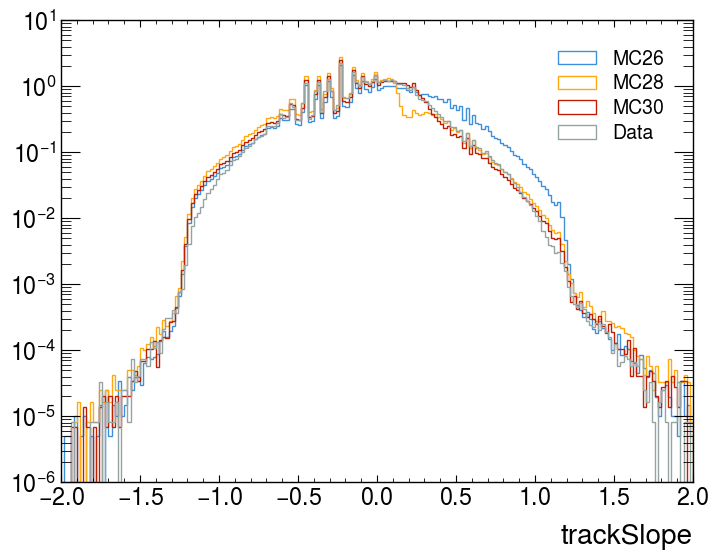

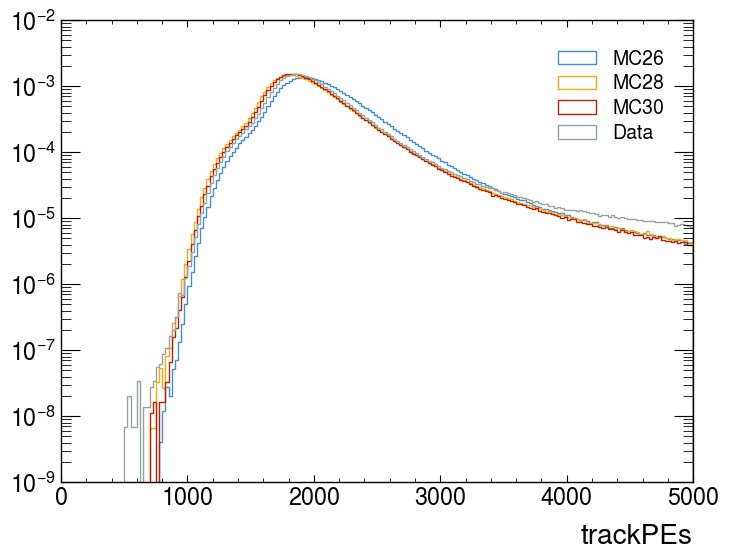

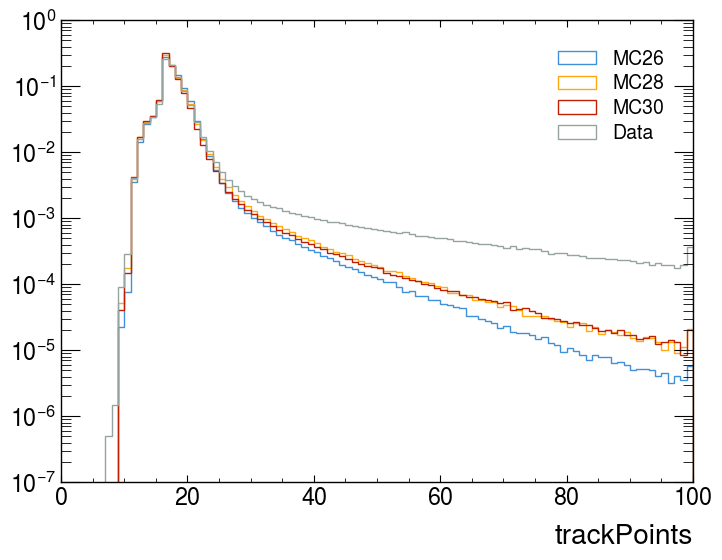

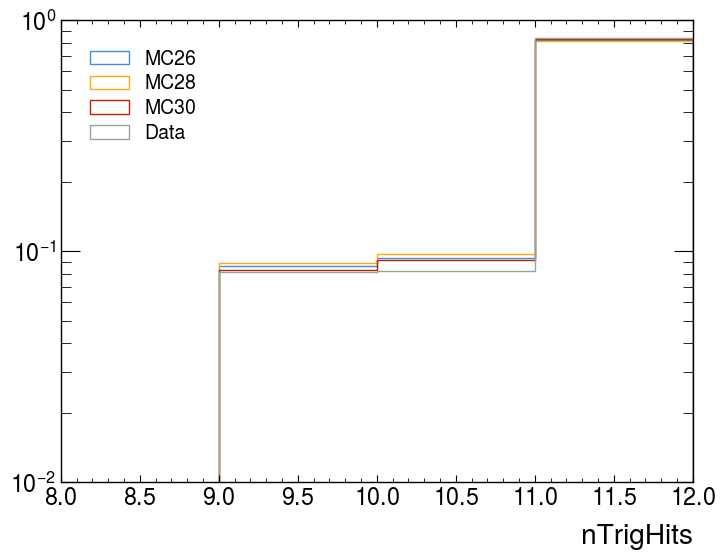

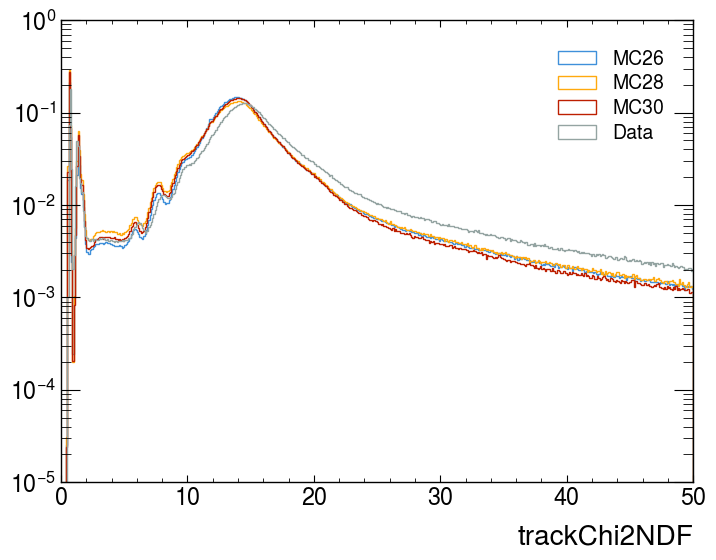

In [39]:
def compare_varibale(var, bins, xmin, xmax):
    plt.figure()
    for data_type in ["MC26", "MC28", "MC30", "Data"]:
        plt.hist(ar_skim[(ar_skim['dataType']==data_type) ][var], 
                 bins=bins, range=(xmin, xmax), 
                 histtype='step', label=data_type, density=True);
    plt.xlabel(var)
    plt.yscale('log')
    plt.legend();

compare_varibale('trackSlope', 200, -2, 2)
compare_varibale('trackPEs', 200, 0, 5000)
compare_varibale('trackPoints', 100, 0, 100)
compare_varibale('nTrigHits', 4, 8, 12)
compare_varibale('trackChi2NDF', 500, 0, 50)

In [45]:
# Cut values
chi2NDF_lower_limit = 0
chi2NDF_upper_limit = 30

#intercept_lower_limit = -700
#intercept_upper_limit = -200

intercept_lower_limit = -1e6
intercept_upper_limit = 1e6

trackPoints_limit = 40
trackPEs_limit = 3000
nTrigHits_limit = 12

# Define the cut conditions
condition_chi2 = (ar_skim["trackChi2NDF"] > chi2NDF_lower_limit) & (ar_skim["trackChi2NDF"] < chi2NDF_upper_limit)
condition_intercept = (ar_skim["trackIntercept"] > intercept_lower_limit) & (ar_skim["trackIntercept"] < intercept_upper_limit)
condition_trackPEs = ar_skim["trackPEs"] < trackPEs_limit
condition_nTrigHits = ar_skim["nTrigHits"] >= nTrigHits_limit
condition_trackPoints = ar_skim["trackPoints"] < trackPoints_limit

# Cut categories
cut_categories = [condition_chi2, 
                  condition_chi2 & condition_nTrigHits, 
                  condition_chi2 & condition_nTrigHits & condition_trackPEs, 
                  condition_chi2 & condition_nTrigHits & condition_trackPEs & condition_intercept, 
                  condition_chi2 & condition_nTrigHits & condition_trackPEs & condition_intercept & condition_trackPoints]

In [46]:
["Data", *MC_labels]

['Data', 'MC25', 'MC26', 'MC27', 'MC28', 'MC29', 'MC30']

In [47]:
# Create histograms
axis1 = hist.axis.IntCategory(label='NHits', name='nhits', categories=[1, 2, 3, 4])
axis2 = hist.axis.StrCategory(label='Cuts', name='cut', categories=["trackChi2", "intercept", "trackPEs", "nTrigHits", "all"])
axis3 = hist.axis.StrCategory(label='Data type', name='dtype', categories=["Data", *MC_labels])
axis4 = hist.axis.IntCategory(label='NLayers', name='layer', categories=[1, 2, 3, 4])

h_nTrigHits = Hist(hist.axis.Regular(6, 8, 14, name="nTrigHits"), axis1, axis2, axis3)
h_PEsTestLayers = Hist(hist.new.Reg(100, 0, 200, name="PEsTestLayers"), axis1, axis2, axis3)
h_trackChi2NDF = Hist(hist.new.Reg(100, 0, 100, name="trackChi2NDF"), axis1, axis2, axis3)
h_trackPEs = Hist(hist.new.Reg(100, 1000, 5000, name="trackPEs"), axis1, axis2, axis3)
h_trackPoints = Hist(hist.new.Reg(80, 0, 80, name="trackPoints"), axis1, axis2, axis3)
h_trackIntercept = Hist(hist.new.Reg(80, -1000, 100, name="trackIntercept"), axis1, axis2, axis3)
h_trackSlope = Hist(hist.new.Reg(80, -1, 1, name="trackSlope"), axis1, axis2, axis3)

h_trackPEsHit = Hist(hist.new.Reg(100, 0, 200, name="trackPEsHit"), axis1, axis2, axis3)

h_PEsLayer = Hist(hist.new.Reg(100, 0, 500, name="PEsLayer", flow=True), axis1, axis2, axis3, axis4)
h_PEsLayerSort = Hist(hist.new.Reg(100, 0, 500, name="PEsLayerSort", flow=True), axis1, axis2, axis3, axis4)

histogram_list = [h_nTrigHits, h_PEsTestLayers, h_trackChi2NDF, 
                  h_trackPEs, h_trackPoints, h_trackIntercept, h_trackSlope]

# Iterate over nhits values and fill the histograms
for data_type in axis3:
    dtype_condition = (ar_skim["dataType"] == data_type)
    for nhits in axis1:
        hits_condition = ar_skim['nTestHits'] <= nhits
        for idx, cut in enumerate(axis2):

            cut_condition = cut_categories[idx] & hits_condition & dtype_condition

            for histogram in histogram_list:
                var_name = histogram.axes[0].label
                if(var_name == "PEsTestLayers"):
                    arr_fill = ak.flatten(ar_skim[cut_condition][var_name])
                else:
                    arr_fill = ar_skim[cut_condition][var_name]
                histogram.fill(arr_fill, nhits=nhits, cut=cut, dtype=data_type)

            h_trackPEsHit.fill(ar_skim[cut_condition]['trackPEs']/ar_skim[cut_condition]['trackPoints'], nhits=nhits, cut=cut, dtype=data_type)

            for layer in axis4:
                h_PEsLayer.fill(ar_skim[cut_condition]['PEsTestLayers'][:,layer-1], nhits=nhits, cut=cut, dtype=data_type, layer=layer)
                h_PEsLayerSort.fill(ak.sort(ar_skim[cut_condition]['PEsTestLayers'], axis=1)[:,layer-1], nhits=nhits, cut=cut, dtype=data_type, layer=layer)

histogram_list.extend([h_trackPEsHit, h_PEsLayerSort, h_PEsLayer])

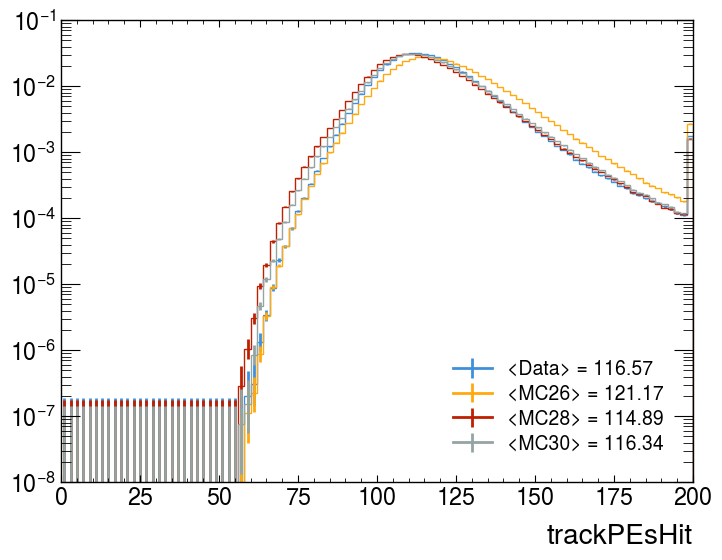

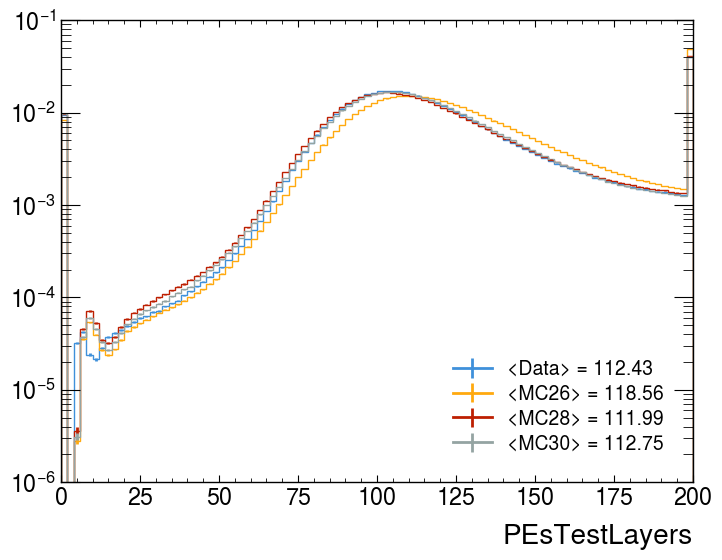

In [55]:
categories = ["Data", "MC26", "MC28", "MC30"]

def compare_hist(hist):
    plt.figure()
    for cat in categories:
        h = hist[:, 3, 'trackChi2', cat]
        mean = np.average(h.axes[0].centers, weights=h.values())
        mplhep.histplot(h, label=f"<{cat}> = {mean:.2f}", density=True, flow="sum")
#    plt.xlim(50, 200)
    plt.yscale('log')
    plt.legend()

compare_hist(h_trackPEsHit)
compare_hist(h_PEsTestLayers)

(0.0, 2.0)

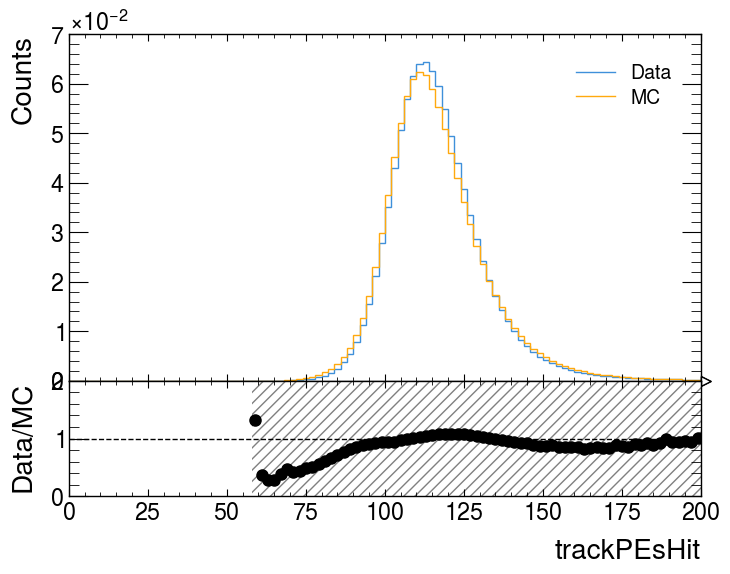

In [61]:
nhits = 4 # the maximum number of layers hit in the test CRV modules 
h_data = h_trackPEsHit[:, nhits-1, 'trackChi2', "Data"]
h_mc = h_trackPEsHit[:, nhits-1, 'trackChi2', "MC30"]
# Normalize each histogram to unity
h_data = h_data/h_data.sum()
h_mc = h_mc/h_mc.sum()

fig = plt.figure()
h_data.plot_ratio(h_mc, rp_ylabel="Data/MC", rp_num_label="Data",
                  rp_denom_label="MC", rp_uncert_draw_type="bar")
ratio_ax = fig.axes[1]
ratio_ax.set_ylim(0, 2)

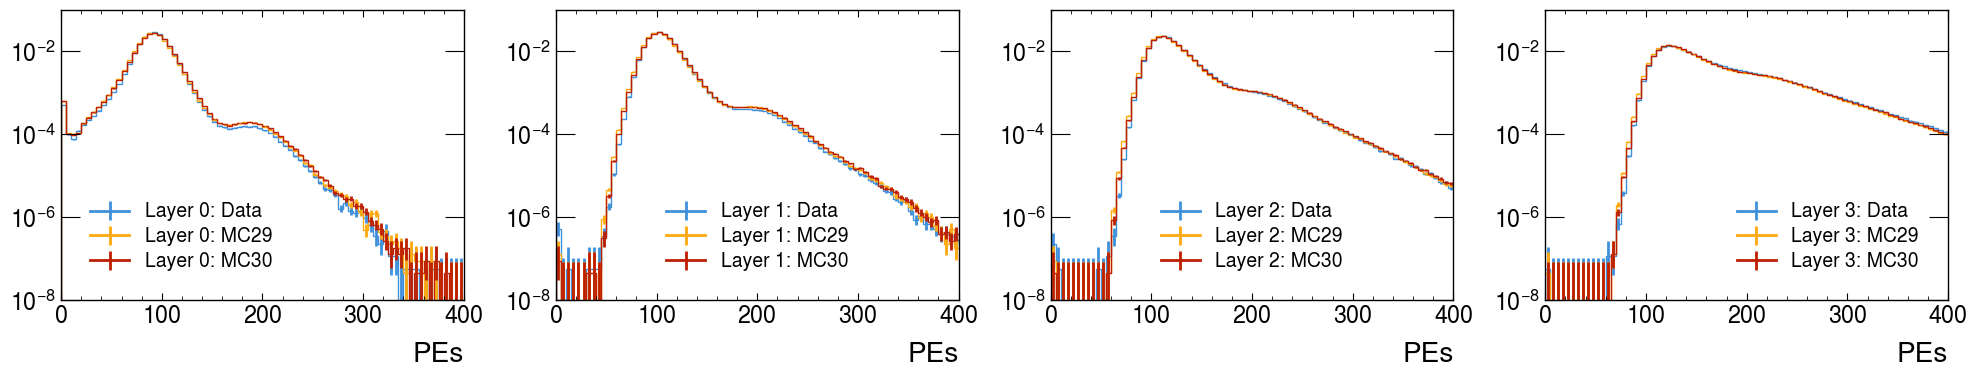

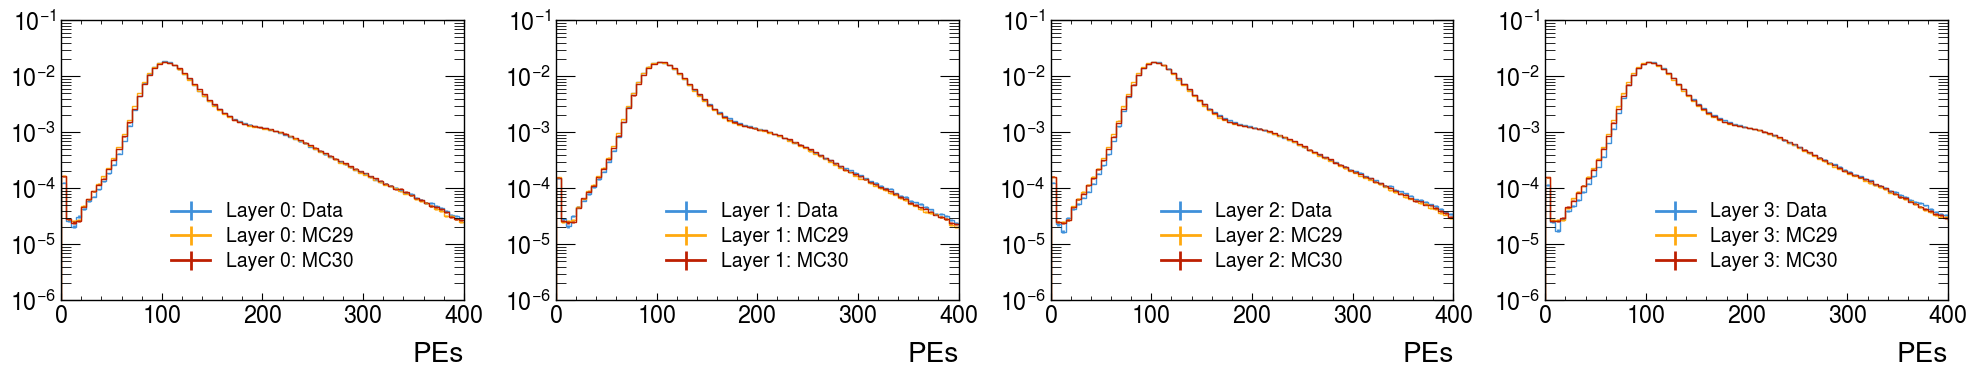

In [64]:
def plot_layer(ax, h_PEsLayer, layer):
    # Loop over the two desired sources only
    for source in ["Data", "MC29", "MC30"]:
        h_PEsLayer[:, 3, "all", source, layer].plot(flow="sum", label=f'Layer {layer}: {source}', density=True, ax=ax)
    ax.set_xlim(0, 400)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel("PEs")

# First set of subplots using h_PEsLayerSort
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for layer, ax in enumerate(axes):
    plot_layer(ax, h_PEsLayerSort, layer)
plt.tight_layout()

# Second set of subplots using h_PEsLayer
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for layer, ax in enumerate(axes):
    plot_layer(ax, h_PEsLayer, layer)
plt.tight_layout()

In [65]:
def get_extrapolated_efficiency(cut, data_type, nfold):
    h = h_PEsLayer[:, 3, cut, data_type, :]
    # Normalize histogram to unity
    normalized_hist = np.mean(h, axis=1) / np.mean(h, axis=1).sum()
    # Calculate cumulative distribution function (CDF)
    cdf = np.cumsum(normalized_hist)
    cdf = binom.cdf(3-nfold, 4, 1 - cdf)
    return cdf

In [66]:
def plot_efficiency(nfold, data_type, cut_type="all"):

    h = h_PEsLayerSort[:, 3, cut_type, data_type, nfold]
    # Normalize histogram to unity
    normalized_hist = h.values() / h.sum(flow=True)

    # Calculate cumulative distribution function (CDF)
    cdf = np.cumsum(normalized_hist)
    cdf = np.clip(cdf, 1e-10, 1 - 1e-10)

    # Calculate the error bars for the CDF
    error_cdf = np.sqrt(cdf * (1 - cdf) / h.sum(flow=True))

    # Plot the normalized histogram and CDF with error bars on the same axis
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Plot the second lowest PEs
    mplhep.histplot(h, ax=ax1, label='PEs per layer: sorted[%d]'%nfold, flow="sum")
    ax1.legend(loc='upper right')
    # Create a second y-axis
    ax2 = ax1.twinx()
    ax2.fill_between(h.axes[0].centers, cdf - error_cdf, cdf + error_cdf, color='red', alpha=0.2, label='Meas. %d/4 inefficiency'%(4-nfold))
    ax2.plot(h.axes[0].centers, cdf, 'r-', linewidth=0.5)

    cdf_est = get_extrapolated_efficiency(cut_type, data_type, nfold)
    ax2.plot(h.axes[0].centers, cdf_est, 'b-', alpha=0.7, label='Extrap. %d/4 inefficiency'%(4-nfold))

    # Set labels for both y-axes
    ax1.set_ylabel('Counts', color='C0')
    ax1.set_xlabel('PEs')
    ax2.set_ylabel('Inefficiency', color='red')
    
    ax2.axhline(y=1E-4, color='red', linestyle='--', label='CRV requirement', linewidth=1)

    plt.legend(loc='upper left')
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    plt.xlim(0, 140);
    plt.ylim(1E-6, 10);

<Figure size 800x600 with 0 Axes>

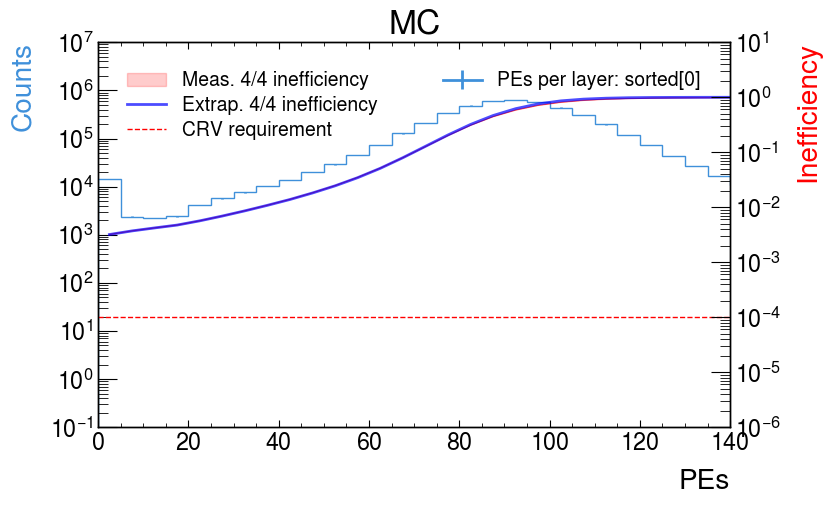

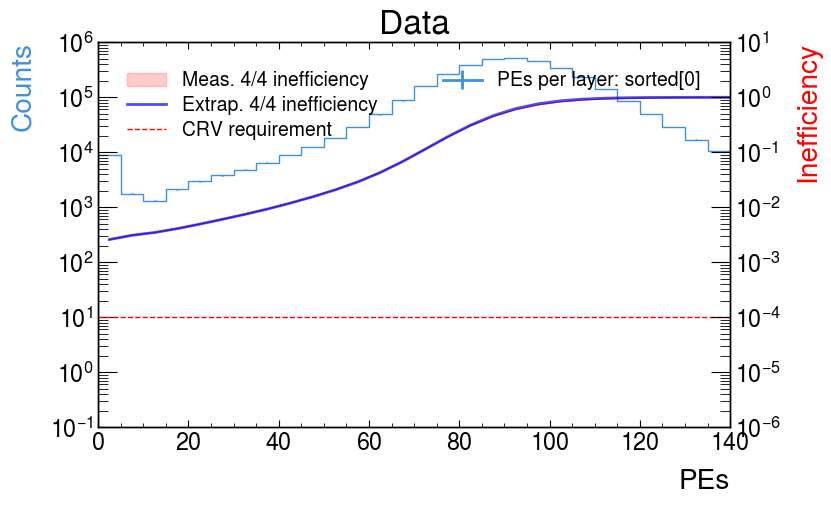

<Figure size 800x600 with 0 Axes>

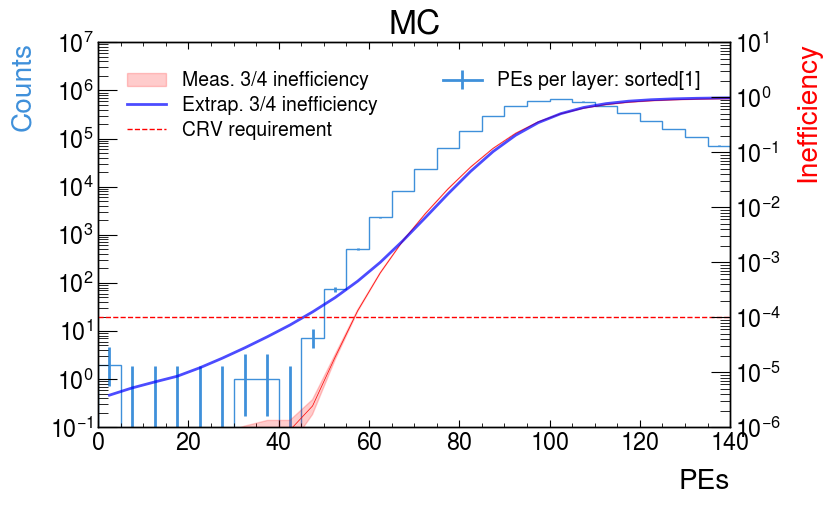

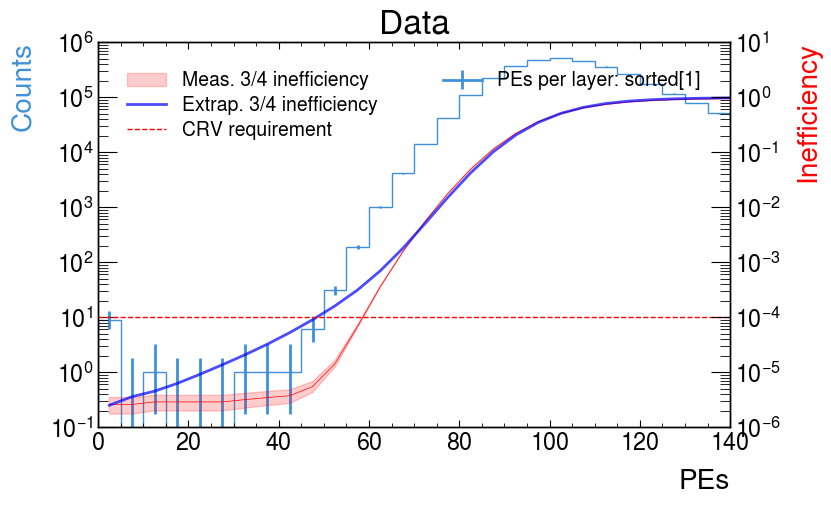

<Figure size 800x600 with 0 Axes>

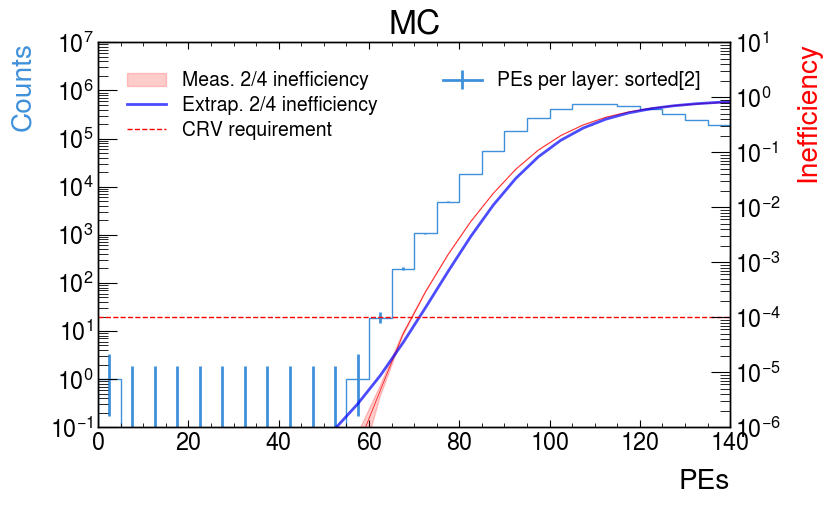

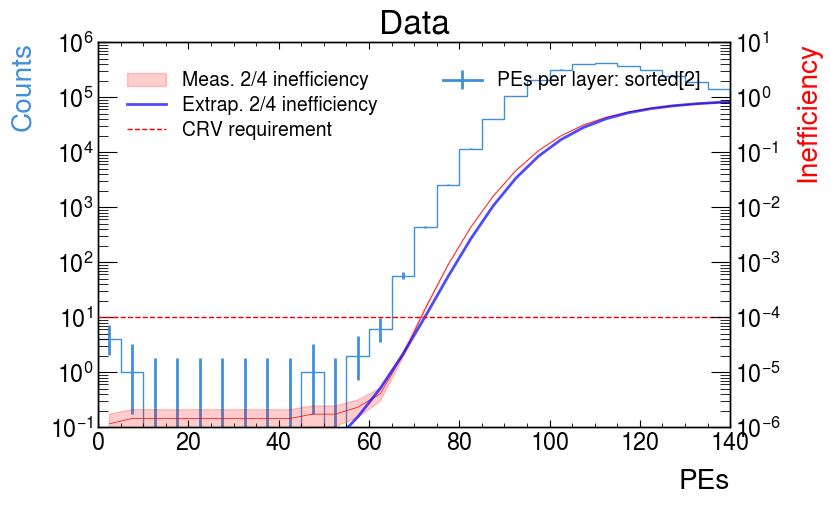

<Figure size 800x600 with 0 Axes>

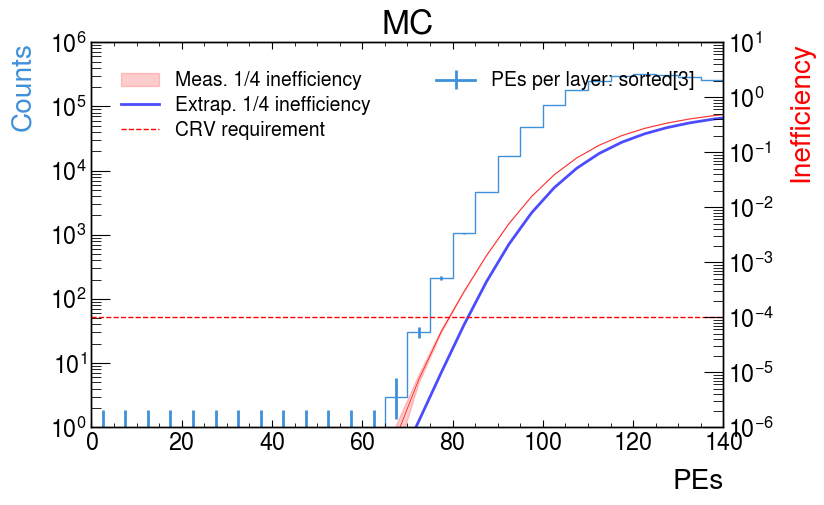

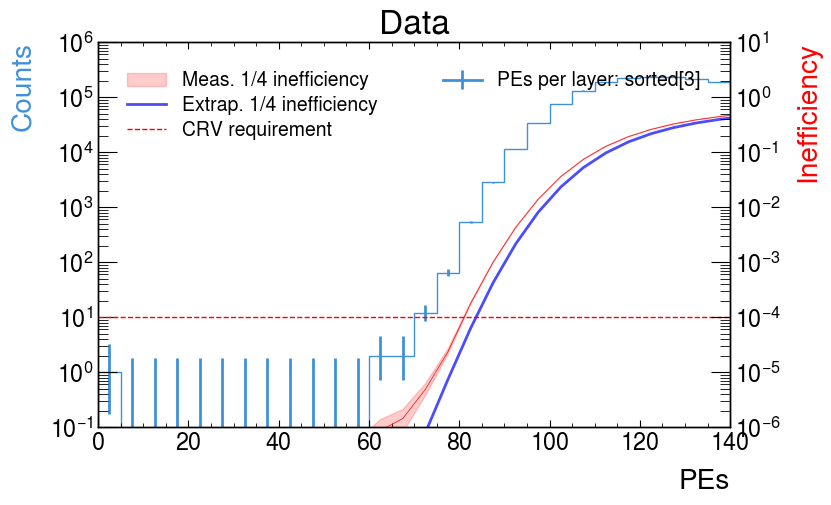

In [67]:
for nfold in range(0,4):
    plt.figure()
    plot_efficiency(nfold, data_type="MC30", cut_type="all");
    plt.title("MC")
    
#    plt.figure()
    plot_efficiency(nfold, data_type="Data", cut_type="all");
    plt.title("Data")

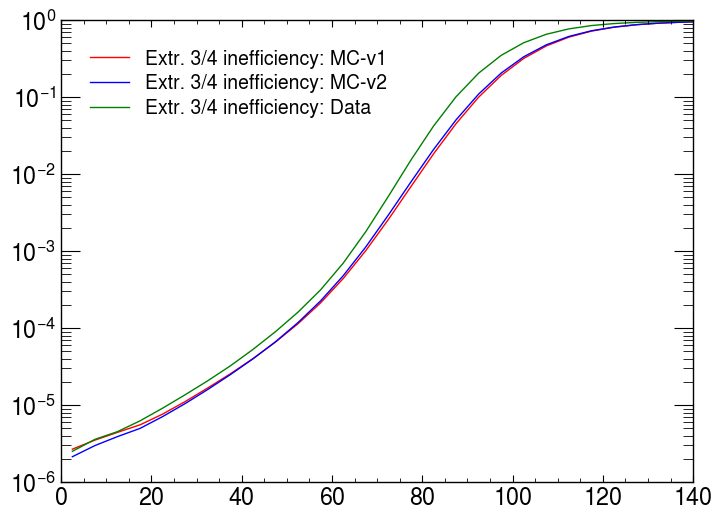

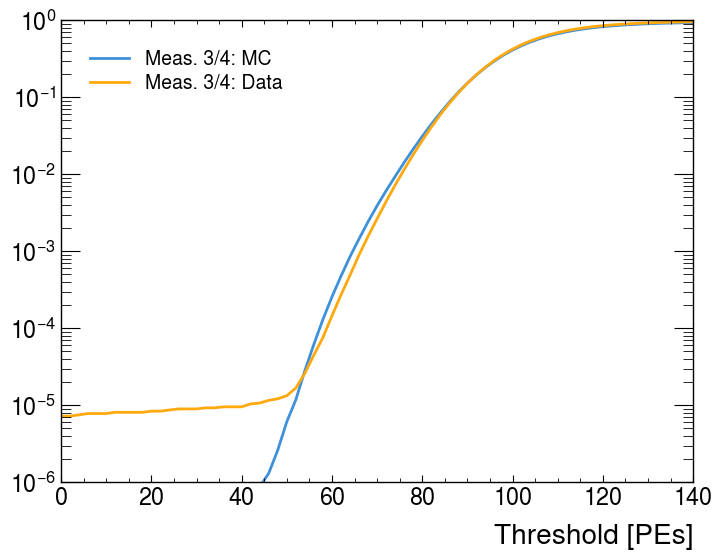

In [74]:
#Plot extrapolated 3/4 measurements
h = h_PEsLayerSort[:, 3, "all", "MC30", 1]
cdf_est = get_extrapolated_efficiency("all", 1, 1)
plt.plot(h.axes[0].centers, cdf_est, 'r-', label='Extr. 3/4 inefficiency: MC-v1', linewidth=1)
cdf_est = get_extrapolated_efficiency("all", 2, 1)
plt.plot(h.axes[0].centers, cdf_est, 'b-', label='Extr. 3/4 inefficiency: MC-v2', linewidth=1)
cdf_est = get_extrapolated_efficiency("all", 0, 1)
plt.plot(h.axes[0].centers, cdf_est, 'g-', label='Extr. 3/4 inefficiency: Data', linewidth=1)
plt.yscale('log');
plt.xlim(0,140);
plt.ylim(1e-6,1);
plt.legend()

#Plot direct 3/4 measurements
plt.figure()
h, edges = np.histogram(ak.sort(ar_skim[cut_categories[1] & (ar_skim["dataType"]=="MC30") ]['PEsTestLayers'], axis=1)[:,1].to_numpy(), bins=1000, range=(0, 2000))
cumulative = np.cumsum(h).astype(float)  # Convert to float
cumulative /= cumulative[-1]
plt.plot(edges[:-1], cumulative,  label='Meas. 3/4: MC')
h, edges = np.histogram(ak.sort(ar_skim[cut_categories[1] & (ar_skim["dataType"]=="Data")]['PEsTestLayers'], axis=1)[:,1].to_numpy(), bins=100, range=(0, 200))
cumulative = np.cumsum(h).astype(float)  # Convert to float
cumulative /= cumulative[-1]
plt.plot(edges[:-1], cumulative, label='Meas. 3/4: Data')
plt.legend()
plt.ylim(1e-6,1);
plt.yscale('log');
plt.xlim(0,140);
plt.xlabel('Threshold [PEs]');

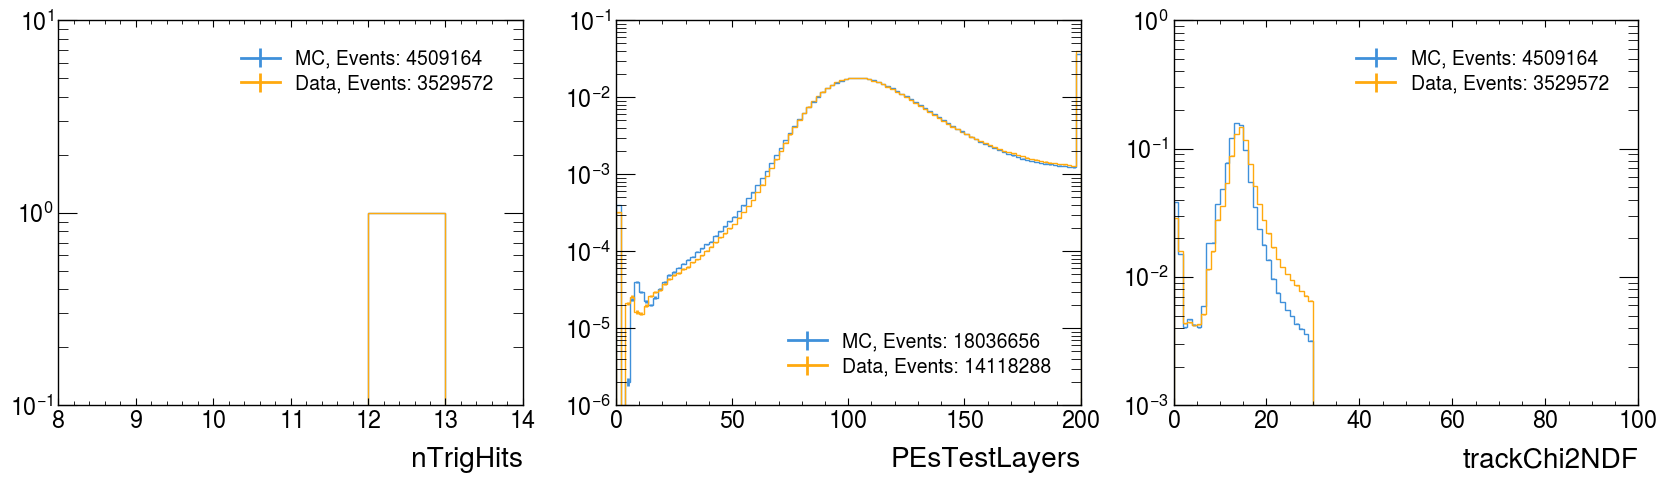

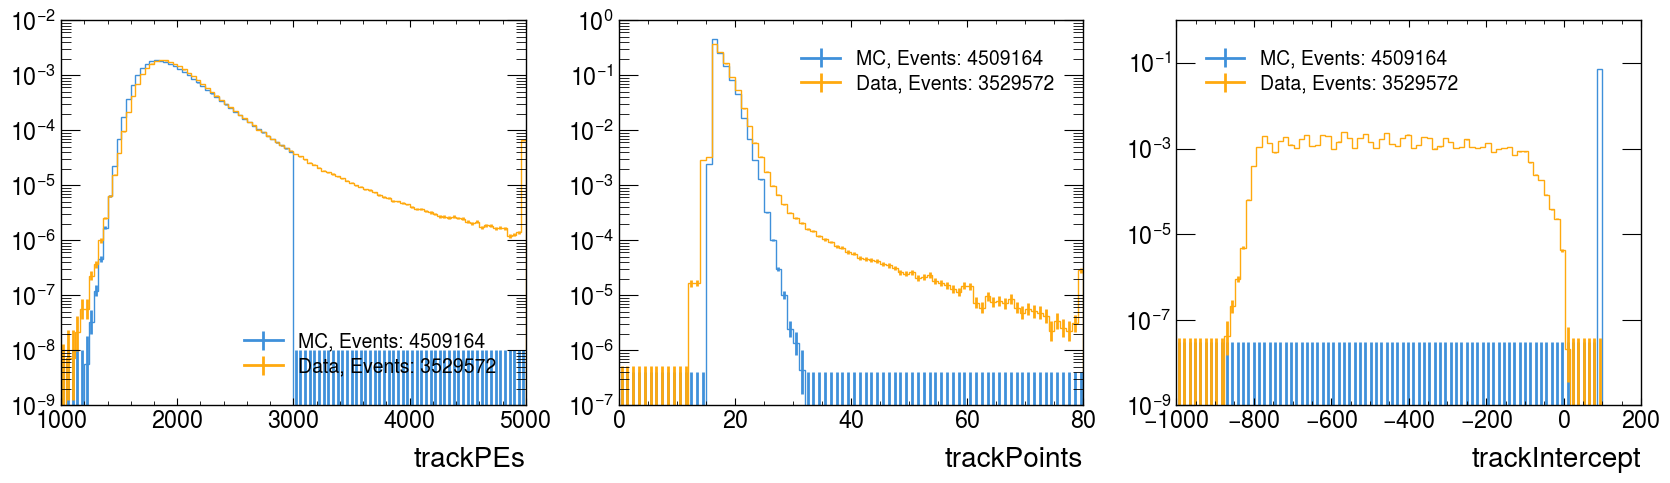

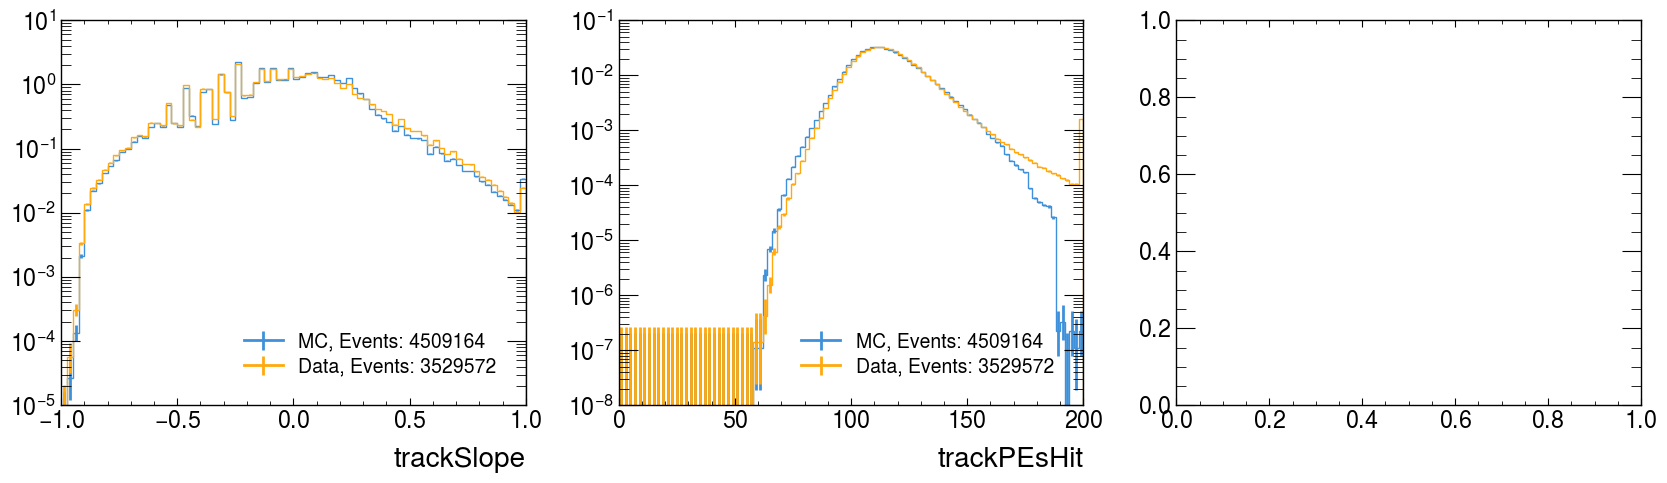

In [68]:
#h_PEsLayer[:, 3, "all", label, layer]

for idx, histogram in enumerate(histogram_list[:-2]):
    ncols = 3
    ax_id = idx%ncols
    if ax_id == 0:
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 5))

#    h = histogram[:, 3, "intercept", 2]
#    mplhep.histplot(h, ax=axes[ax_id], label="MC, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")

    h = histogram[:, 3, "all", "MC30"]
    mplhep.histplot(h, ax=axes[ax_id], label="MC, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")

    h = histogram[:, 3, "intercept", "Data"]
    mplhep.histplot(h, ax=axes[ax_id], label="Data, Events: %d"%h.to_numpy(flow=True)[0].sum(), density=True, flow="sum")
    
    axes[ax_id].set_xlabel(histogram.axes[0].label)
    axes[ax_id].legend()
    axes[ax_id].set_yscale('log')

Distributions before any cuts 

In [75]:
#Apply cuts
ar_skim['nTestHits'] = ak.sum(ar_skim['PEsTestLayers'] > 10, axis=-1)
ar_3l = ar_skim[cut_categories[1] & (ar_skim['nTestHits']<3) & (ar_skim['dataType']=="Data")]  # less than 3 hits
ar_4e = ar_skim[cut_categories[1] & (ar_skim['nTestHits']==4) & (ar_skim['dataType']=="MC30")] # equal to 4 hits

In [76]:
ar_skim_fields = ar_skim.fields.copy()
ar_skim_fields.remove('PEsTestLayers')

In [79]:
pd.set_option('display.max_rows', None)
ak.to_dataframe(ar_3l[ar_skim_fields]).head()

runNumber  subrunNumber  spillNumber  eventNumber  \
entry subentry                                                      
0     0              2027             0          209           31   
      1              2027             0          209           31   
      2              2027             0          209           31   
      3              2027             0          209           31   
      4              2027             0          209           31   

                PEsAllLayer  nTrigHits  PEsTrigLayers dataType  trackPoints  \
entry subentry                                                                
0     0          127.165821         12     127.165821     Data           22   
      1           99.500779         12      99.500779     Data           22   
      2           89.881809         12      89.881809     Data           22   
      3          199.965743         12     199.965743     Data           22   
      4           41.877041         12     521.714096     Data           22   

                 trackChi2  trackSlope  trackIntercept     trackPEs  \
entry subentry                                                        
0     0         584.643127   -0.148307     -275.251862  4111.552734   
      1         584.643127   -0.148307     -275.251862  4111.552734   
      2         584.643127   -0.148307     -275.251862  4111.552734   
      3         584.643127   -0.148307     -275.251862  4111.552734   
      4         584.643127   -0.148307     -275.251862  4111.552734   

                trackChi2NDF  nTestHits  
entry subentry                           
0     0            29.232156          2  
      1            29.232156          2  
      2            29.232156          2  
      3            29.232156          2  
      4            29.232156          2

In [78]:
eff = len(ar_3l)/len(ar_4e)
print("Efficiency at 10 PE: %.2e"%eff)

Efficiency at 10 PE: 5.91e-06
